In [2]:
import numpy as np
import matplotlib.pyplot as py

constants are defined below

The spiral b constant is related to the other parameters with this equation.
$$
b = \frac{vT_{spin}}{2\pi}
$$

In [3]:
v = 600 # wind speed km/s
T = 25.67 # sun period in days
L = 1/60 # lisa arm length in AU
width = np.pi/12 #thickness of spiral in radians
daytosecond = 86400 #seconds per day
AUtokm = 149600000 #km per AU
rotation = np.pi/2 #LISA pre-rotation around z axis

bgdensity = 3
spiraldensity = 5 #electron density of the background and the spiral per cm^-3

b = v*(1/AUtokm)*T*daytosecond/(np.pi*2) #spiral b
armres = 250 #resolution of each lisa arm



The conversion between cartesian and spherical can be seen below. The equations for $r$, $\theta$, and $\phi$ are:

$$
r = \sqrt{x^2 + y^2 + z^2}
$$

$$
\theta = \arccos{\frac{z}{r}} = \arccos{\frac{z}{\sqrt{x^2 + y^2 + z^2}}}
$$

$$
\phi = \arccos{\frac{x}{\sqrt{x^2+y^2}}}
$$

In [4]:
def cartToSpheric(x,y,z): #theta and phi found from wikipedia
    r = np.sqrt(x**2 + y**2 + z**2) #euclidian distance
    
    theta = np.arccos(z/r)
    
    phi = np.arccos(x/np.sqrt(x**2 + y**2)) * np.sign(y)
    
    return np.array([r, theta, phi])

The rotation matrix defined below is taken directly from wikipedia - defined as:



$$
\left [
\begin{matrix} \cos{\alpha}\cos{\beta}& \cos{\alpha}\sin{\beta}\sin{\gamma} - \sin{\alpha}\cos{\gamma}& \cos{\alpha}\sin{\beta}\cos{\gamma} + \sin{\alpha}\sin{\gamma} \\ 
\sin{\alpha}\cos{\beta}& \sin{\alpha}\sin{\beta}\sin{\gamma} + \cos{\alpha}\cos{\gamma}& \sin{\alpha}\sin{\beta}\cos{\gamma} - \cos{\alpha}\sin{\gamma} \\
-\sin{\beta}& \cos{\beta}\sin{\gamma}& \cos{\beta}\cos{\gamma}
\end{matrix}
\right ]
$$

where the rotations are:
$$
R = R_z(\alpha)R_y(\beta)R_x(\gamma)
$$

In [5]:
def eulerRot3D(RotObj, Xangle, Yangle, Zangle):
    
    sa = np.sin(Zangle) #sin and cos of x,y,z angles
    ca = np.cos(Zangle)
    sb = np.sin(Yangle)
    cb = np.cos(Yangle)
    sc = np.sin(Xangle)
    cc = np.cos(Xangle)
    
    rotmat = np.array([[ca*cb, ca*sb*sc - sa*cc, ca*sb*cc + sa*sc], [sa*cb, sa*sb*sc + ca*cc, sa*sb*cc - ca*sc], [-sb, cb*sc, cb*cc]])
    
    return np.matmul(rotmat, RotObj)
    
    

The average density over the arm length is calculated below. It takes the densities per $cm^{-3}$ at different points on the laser (based on the laser resolution), and outputs the average density per $cm^{-3}$ over the whole laser. The laser can be assumed to have an area of 1 $cm^2$, meaning that the line integral of the electron count over the laser is just the average density in $cm^{-3}$ (as opposed to $m^{-3}$) times the laser length.

In [21]:
def avgDens(armlen, armrot, armres, armidx, orbitang, spiralb, spiraldens, bgdens):
    
    
    start = np.array([armlen/np.sqrt(3) * np.cos(armrot + (armidx)*2*np.pi/3), armlen/np.sqrt(3) * np.sin(armrot + (armidx)*2*np.pi/3), 0]) #defining start and end coordinates of the arm
    end = np.array([armlen/np.sqrt(3) * np.cos(armrot + (armidx+1)*2*np.pi/3), armlen/np.sqrt(3) * np.sin(armrot + (armidx+1)*2*np.pi/3), 0])
    
    pos = np.array([start, end])
    pos = (pos + np.array([0,1,0])).T #offsetting points by 1au in the y direction
    pos = eulerRot3D(pos, 0, 0, orbitang) #rotating points around an orbit by the specified 'orbitang' angle
    
    X = np.linspace(pos[0,0], pos[0,1], armres) #subdividing laser arm to the specified resolution
    Y = np.linspace(pos[1,0], pos[1,1], armres)
    Z = np.linspace(pos[2,0], pos[2,1], armres)
    
    sphericoords = cartToSpheric(X,Y,Z)
    
    r = sphericoords[0] #below is the math worked out in the math pdf.
    phi = sphericoords[2]
    
    spiralphi = r/spiralb #finding the phi angle of the spiral at the point's distance from 0
    

    densvect = np.where((phi > spiralphi % (2*np.pi)) & (phi < (spiralphi + width) % (2*np.pi)), spiraldens, bgdens) #checking between phi and phi+width. If true, multiply by higher density. Otherwise, by lower density.
    avgdens = np.sum(densvect)/armres #average over arm
    #not multiplying by L because it gets cancelled out later
    return avgdens

This part gives the average density for each arm, over multiple angles. The angles are related to the time by a simple conversion - to go from angle to time, divide by $2\pi$ (to normalize), then multiply by the orbital period (25.67 days in this case). This will give the position of the spacecraft as a function of time. By default, the input for rotation is in radians, and needs to be converted to time before inputting into the `avgDens` function.

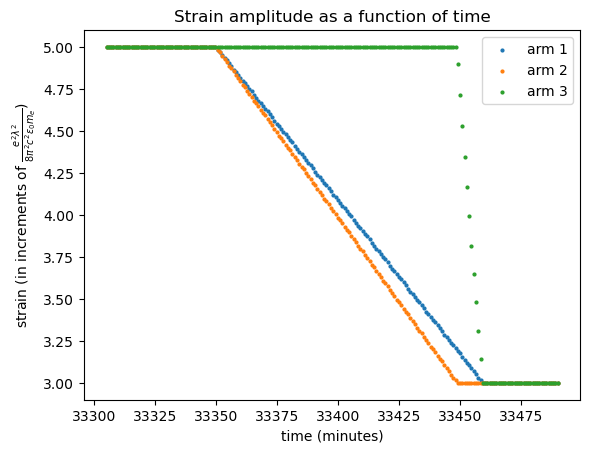

In [23]:

time = np.linspace(0.901*T,0.906*T, 200) #set time to evaluate densities
angles = time * 2*np.pi/T #convert to angle



for i in range(3): #for each arm
    avgdens = []
    
    for j in angles: #for each angle
        avgdens.append(avgDens(L, rotation, armres, i, j, b, spiraldensity, bgdensity))
    
    
    
    py.scatter(time*24*60, avgdens, s=4, label='arm '+str(i+1)) #for each arm, plot for all angles
py.title('Strain amplitude as a function of time')
py.xlabel('time (minutes)')#NOTE change to minutes
py.ylabel('strain (in increments of $\\frac{e^2\lambda^2}{8\pi^2c^2\epsilon_0m_e}$)') #labelling output graph
py.legend()
py.show()
    

Strain is represented as:

$$
h(t) = \frac{\Delta L}{L}
$$

where 

$$
\Delta L \propto \Delta \eta
$$
$\eta$ being the refractive index of the medium. It can be represented as such:

$$
\eta = \sqrt{1-\frac{\omega_p^2}{\omega^2}} \approx 1-\frac{1}{2}\frac{\omega_p^2}{\omega^2}
$$
$$
|\Delta \eta| \approx \frac{1}{2}\frac{\omega_p^2}{\omega^2} = \frac{1}{2} \frac{n_ee^2}{\epsilon_0m_e\omega^2}
$$

Where $n_e$ is the electron number density, and $\omega$ is the laser's angular frequency. 
$$
\omega = 2\pi f = \frac{2 \pi c}{\lambda}
$$
replacing this back yields:

$$
\Delta \eta = \frac{e^2\lambda^2}{8\pi^2c^2\epsilon_0m_e} n_e
$$


optical path length:

$$
L_{opt} = \int_0^L \eta ds
$$

$$
L_{opt} - L = L + \Delta L - L = \Delta L
$$
$$
\Delta L = \int_0^L \eta ds - \int_0^L 1 ds = \int_0^L 1 + \Delta \eta ds - \int_0^L 1 ds = \int_0^L \Delta \eta ds
$$
$$
\int_0^L \Delta \eta ds = \int_0^L \frac{e^2\lambda^2}{8\pi^2c^2\epsilon_0m_e} n_e ds = \frac{e^2\lambda^2}{8\pi^2c^2\epsilon_0m_e} \int_0^L n_e ds = \frac{e^2\lambda^2}{8\pi^2c^2\epsilon_0m_e} n_{average}L
$$

$$
strain = h(t) = \frac{\Delta L}{L} = \frac{e^2\lambda^2}{8\pi^2c^2\epsilon_0m_e} n_{average}
$$

Or equivalently:

$$
h(t) = K n_{average}
$$
where

$$
K = \frac{e^2\lambda^2}{8\pi^2c^2\epsilon_0m_e}
$$
self note : careful of units - $n_{average}$ is in $cm^{-3}$, which means $\epsilon_0$ has to be converted.

eval const (note, all SI units):

$$
e = 1.602*10^{-19}\\
\lambda = 1.064*10^{-6}\\
c = 2.998*10^8\\
\epsilon_0 = 8.854*10^{-12}\\
m_e =9.109*10^{-31} \\
$$

assuming $n_{average}$ is roughly 5 electrons/$cm^{-3}$
$$
K = 5.08 * 10^{-28}\\
h = K*n_{average} = 5.08 * 10^{-28} * 5*10^6 \approx 10^{-21}
$$

In [9]:
e = 1.602E-19
lam = 1.064E-6
c = 2.998E8
eps0 = 8.854E-12
me =9.109E-31

K = (e**2 * lam**2) / (8 * np.pi**2 * c**2 * eps0 * me)
print(K) #note, SI units - n_average would be 1 000 000x larger, hence strain would be 6 orders of magnitude bigger (ie. 10^-22)

5.0762741694595954e-28
